<a href="https://colab.research.google.com/github/maronem/PyTorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch CUstom Datasets Notebook

**RESOURCES**
* Book version of course materials: https://www.learnpytorch.io/04_pytorch_custom_datasets/

### Domain Libraries
Depending on what you are working on, vision, text, audio, reccomendation... you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions


## 0. Importing pytorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

# We need PyTorch 1.10.0
torch.__version__

'2.0.0+cu118'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Mon Apr 24 18:18:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get Data

Our dataset is a subset of the Food101 Dataset.

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why? When starting ML projects, it is important to try things on a smaller scale then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} already exists, skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,
                   exist_ok=True)

data/pizza_steak_sushi does not exist, creating one...


In [5]:
# Download pizza_steak_sushi data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza_steak_sushi.zip...")
  f.write(request.content)

# Unzip data file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data file...")
  zip_ref.extractall(image_path)


Unzipping data file...


## 2. Becoming one with the data (data preparation and data exploration)

In [6]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents.
    Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdirectories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [7]:
# Setup training and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image 

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's [PIL](https://pillow.readthedocs.io/en/stable/)
5. Show the image and print metadata

In [8]:
image_path

PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi/train/steak/1225762.jpg
steak
Random img path: data/pizza_steak_sushi/train/steak/1225762.jpg
Img class: steak
Img Height: 512
Img Width: 289


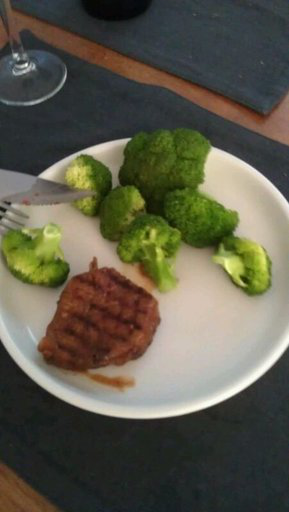

In [9]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))


# 2. Pick random image path
random_img_path = random.choice(image_path_list)
print(random_img_path)

# 3. Get image class from path name
image_class = random_img_path.parent.stem
print(image_class)

# 4. Open img using PIL
img = Image.open(random_img_path)

# 5. Print metadata
print(f"Random img path: {random_img_path}")
print(f"Img class: {image_class}")
print(f"Img Height: {img.height}")
print(f"Img Width: {img.width}")
img

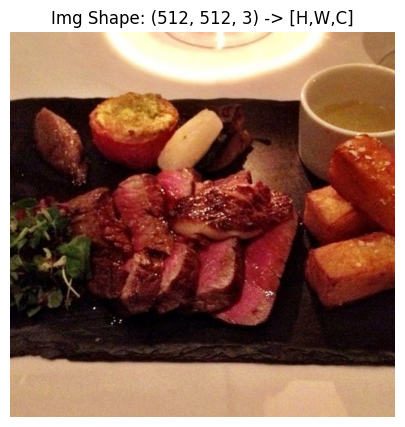

In [10]:
# Challenge: Try to visualize random img using matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Open img with PIL and convert to np array
img_array = np.asarray(Image.open(random.choice(image_path_list))) # dtype = uint8
#print(repr(img_array))

# Plot np array as img
plt.figure(figsize=(8,5))
plt.imshow(img_array)
plt.title(f"Img Shape: {img_array.shape} -> [H,W,C]")
plt.axis(False);

## 3. Transforming Data

Before we can use our iamge data with PyTorch:
1. Turn target data into tensors (numerical represenation of iamges)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvisions.transforms`

Transforms help you get your images ready to use with a model / data augmentation - https://pytorch.org/vision/stable/transforms.html

In [12]:
# Write a transform for image

data_transform = transforms.Compose([
    # Resize img's to 64x64
    transforms.Resize(size=(64,64)),
    # Flip imgs randomly on horizontal (data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn img into a torch.Tensor
    transforms.ToTensor() #takes nparray values HWC and converts to torch float tensor CHW
])

In [13]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

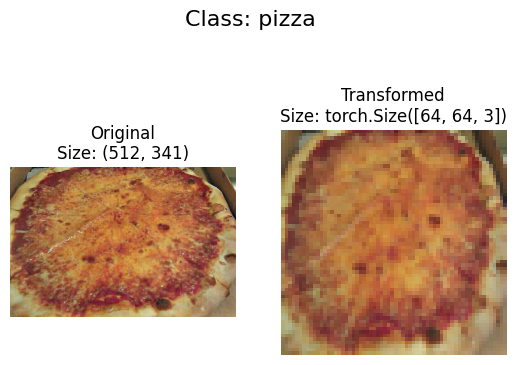

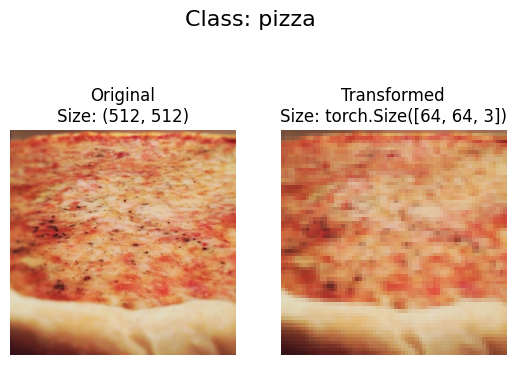

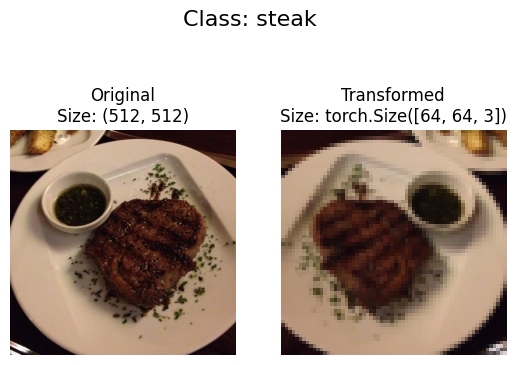

In [19]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them; 
  then plots the original vs. tranformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) #Note we will need to chagne shape for mpl.plt (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

In [ ]:
image_path_list

## 4. Option 1: Loading image data using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder

In [20]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the labels/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data                                 

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [21]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [22]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [23]:
# Check lengths of our dataset
len(train_data), len(test_data)

(225, 75)